In [2]:
!pip install pystac-client
!pip install planetary_computer
!pip install geopandas
!pip install rich
!pip install IPython
!pip install rioxarray
!pip install 'stackstac[viz]'
!pip install contextily
!pip install earthpy
!pip install --ignore-installed Pillow==9.0.0


  Using cached Pillow-9.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.0 requires opencv-python-headless>=4.1.1, which is not installed.


In [3]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
catalog

id: microsoft-pc
title: Microsoft Planetary Computer STAC API
description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer
type: Catalog
"conformsTo: ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30', 'http://www.opengis.net/spec/ogcapi-features-3/1.0/conf/filter', 'https://api.stacspec.org/v1.0.0-rc.1/collections', 'https://api.stacspec.org/v1.0.0-rc.1/core', 'https://api.stacspec.org/v1.0.0-rc.1/item-search', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#fields', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:basic-cql', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-json', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-text', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#query', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#sort', 'https://api.stacspec.org/v1.0.0-rc.1/ogcapi-features']"
id: daymet-annual-pr
title: Daymet Annual Puerto Rico
"description: Annual climate summaries derived from [Daymet](https://daymet.ornl.gov) Version 4 daily data at a 1 km x 1 km spatial resolution for five variables: minimum and maximum temperature, precipitation, vapor pressure, and snow water equivalent. Annual averages are provided for minimum and maximum temperature, vapor pressure, and snow water equivalent, and annual totals are provided for the precipitation variable. [Daymet](https://daymet.ornl.gov/) provides measurements of near-surface meteorological conditions; the main purpose is to provide data estimates where no instrumentation exists. The dataset covers the period from January 1, 1980 to the present. Each year is processed individually at the close of a calendar year. Data are in a Lambert conformal conic projection for North America and are distributed in Zarr and NetCDF formats, compliant with the [Climate and Forecast (CF) metadata conventions (version 1.6)](http://cfconventions.org/). Use the DOI at [https://doi.org/10.3334/ORNLDAAC/1852](https://doi.org/10.3334/ORNLDAAC/1852) to cite your usage of the data. This dataset provides coverage for Hawaii; North America and Puerto Rico are provided in [separate datasets](https://planetarycomputer.microsoft.com/dataset/group/daymet#annual)."
"providers: Microsoft (host, processor) ORNL DAAC (producer)"
type: Collection
sci:doi: 10.3334/ORNLDAAC/1852


In [4]:
#Corredor de Conectividad Forestal Tuxtla
time_range = "2020-12-01/2020-12-31"
bbox = [-93.94014626199998,16.62133275800005,-92.94152895399998,17.22537810600005]

# search = catalog.search(collections=["sentinel-2-l2a"], bbox=bbox, datetime=time_range)
# items = search.get_all_items()
# len(items)


search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=bbox,
    datetime=time_range,
    query={"eo:cloud_cover": {"lt": 10}},
)
items = search.get_all_items()

len(items)

16

<jemalloc>: MADV_DONTNEED does not work (memset will be used instead)
<jemalloc>: (This is the expected behaviour if you are running under QEMU)


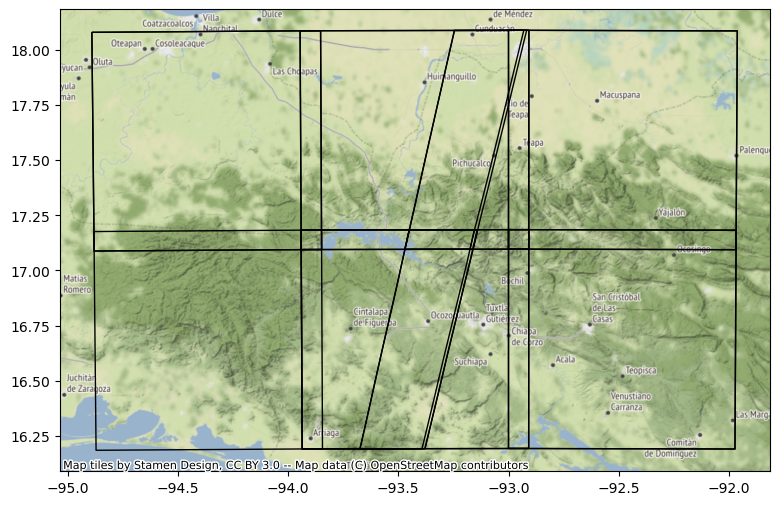

In [5]:
import contextily
import geopandas

df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

ax = df[["geometry", "datetime", "s2:mgrs_tile", "eo:cloud_cover"]].plot(
    facecolor="none", figsize=(12, 6)
)
contextily.add_basemap(ax, crs=df.crs.to_string());

In [6]:
import geopandas
df = geopandas.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
# selected_item = max(items, key=lambda item: item.properties["eo:cloud_cover"])

selected_item = items[0]
# raster_ams_b9 = rioxarray.open_rasterio(items[0].assets["B09"].href)
selected_item

id: S2A_MSIL2A_20201231T164711_R126_T15QVV_20210101T074041
"bbox: [-93.945435, 17.09440548579995, -92.930756, 18.08899762556261]"
datetime: 2020-12-31T16:47:11.024000Z
platform: Sentinel-2A
proj:epsg: 32615
instruments: ['msi']
s2:mgrs_tile: 15QVV
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20210101T074042_A028866_T15QVV_N02.12
eo:cloud_cover: 0.130956
s2:datatake_id: GS2A_20201231T164711_028866_N02.12


In [7]:
import rich.table
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in selected_item.assets.items():
    table.add_row(asset_key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key          ┃ Description                           ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ AOT                │ Aerosol optical thickness (AOT)       │
│ B01                │ Band 1 - Coastal aerosol - 60m        │
│ B02                │ Band 2 - Blue - 10m                   │
│ B03                │ Band 3 - Green - 10m                  │
│ B04                │ Band 4 - Red - 10m                    │
│ B05                │ Band 5 - Vegetation red edge 1 - 20m  │
│ B06                │ Band 6 - Vegetation red edge 2 - 20m  │
│ B07                │ Band 7 - Vegetation red edge 3 - 20m  │
│ B08                │ Band 8 - NIR - 10m                    │
│ B09                │ Band 9 - Water vapor - 60m            │
│ B11                │ Band 11 - SWIR (1.6) - 20m            │
│ B12                │ Band 12 - SWIR (2.2) - 20m            │
│ B8A                │ Band 8A - Vegetation red edge 4 - 20m │
│ SCL                │ Scene classfication map (SCL)         │
│ WVP                │ Water vapour (WVP)                    │
│ visual             │ True color image                      │
│ preview            │ Thumbnail                             │
│ safe-manifest      │ SAFE manifest                         │
│ granule-metadata   │ Granule metadata                      │
│ inspire-metadata   │ INSPIRE metadata                      │
│ product-metadata   │ Product metadata                      │
│ datastrip-metadata │ Datastrip metadata                    │
│ tilejson           │ TileJSON with default rendering       │
│ rendered_preview   │ Rendered preview                      │
└────────────────────┴───────────────────────────────────────┘

In [8]:
selected_item.assets["rendered_preview"].to_dict()


{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20201231T164711_R126_T15QVV_20210101T074041&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0&format=png',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

# Show RGB preview


In [9]:
from IPython.display import Image
Image(url=selected_item.assets["rendered_preview"].href, width=200)

# Display all bands 


In [10]:
# 
import rioxarray
from rioxarray.merge import merge_arrays
import numpy as np

def read_bands(bands):
  vv_list=[]
  for band in bands:
    href = selected_item.assets[band].href
    ds = rioxarray.open_rasterio(href)
    print(f"{band}, {ds.shape}")
    vv_list.append(ds)
  # arr_st = np.stack(vv_list)
  return vv_list



In [11]:
bands_10m=["B02","B03", "B04","B08"]
# bands_10m=["B02","B03", "B04"]
bands_20m=["B05","B06", "B07","B11","B12", "B8A"]
bands_60m=["B01","B09"]
vv_list_10m = read_bands(bands_10m)
# vv_list_20m = read_bands(bands_20m)
# vv_list_60m = read_bands(bands_60m)




B02, (1, 10980, 10980)
B03, (1, 10980, 10980)
B04, (1, 10980, 10980)
B08, (1, 10980, 10980)


In [ ]:
#Plot the coherence for each of the four polarizations (HH, HV, VH, VV)
from matplotlib import pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

vv_list_10m[0].plot(ax=axs[0, 0], cmap='viridis')
axs[0, 0].set_title('HH')

# vv_list_10m[1].plot(ax=axs[0, 1], cmap='viridis')
# axs[0, 1].set_title('HV')

# vv_list_10m[2].plot(ax=axs[1, 0], cmap='viridis')
# axs[1, 0].set_title('VH')

# vv_list_10m[3].plot(ax=axs[1, 1], cmap='viridis')
# axs[1, 1].set_title('VV')

fig.suptitle('Bands with 10m')

plt.show()

In [ ]:
#gist_earth para mostrar like a RGB
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import matplotlib.pyplot as plt

ep.plot_bands(mosaic_sentinel, cmap = 'gist_earth', figsize = (20, 12), cols = 6, cbar = False)
plt.show()